In [76]:
# importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import loguniform
import scipy.stats as stats
import mr_forecast
from astropy.io import ascii
from scipy.stats import bernoulli
import math
import torch
import forecaster
import cProfile


In [77]:
# P(detection|SNR)

def p_det_given_snr(snr, bl=8.06,cl=8.11,dl=0.995):
    
    return dl - dl/(1+(snr/cl)**bl)

def select_stars(catalog_df):
    return catalog_df.sample(1)

def inject_planets(distribution,b):

    # a = np.random.choice([0,1],p=[0.5,0.5])
    # if a == 1:
    #     a1 = np.random.uniform(low=b_m-minus,high=b_m)
    # elif a == 0:
    #     a1 = np.random.uniform(low=b_m,high=b_m+plus)

    if distribution == "constant":
        m = np.round(b)

    if distribution == "uniform":
        m = -1
        while m<0:
            m = np.ceil(np.random.uniform(low = b, high = 10))

    if distribution == "zipfian":
        m = 11
        while m > 10 or m < 0:
            m = np.random.zipf(1+b)
            m = np.round(m)

    if distribution == "poisson":
        m = 11
        while m > 10 or m < 1:
            m = m = np.random.poisson(b)
            m = np.round(m)
    
    return int(m)

def assign_periods(planets):
    if planets>0:
        periods = np.sort(loguniform.rvs(6.25, 400, size=planets))
    else:
        periods = np.array([])
    return np.array(periods)


def assign_radii(planets,rcrit, alpha_small, alpha_big, sigma, rmin = 0.5, rmax = 32):

    if planets == 0 :
    
        return np.array([])
    
    else:
    # Initialize an empty list to store the sampled radii
        radii = []
        
        # Generate uniform random values for the log of radii
        u = np.random.rand(1)[0]
        # Define total normalization factor
        norm_small = (np.log10(rcrit) - np.log10(rmin))**alpha_small
        norm_big = (np.log10(rmax) - np.log10(rcrit))**alpha_big
        total_norm = norm_small + norm_big
        
        if u < norm_small / total_norm:
            # Sample from the region [rmin, rcrit] with prob ~ (log10(r) - log10(rmin))^alpha_small
            prob_r = np.random.uniform(np.log10(rmin), np.log10(rcrit))
            radii.append(10**(prob_r))
        else:
            # Sample from the region [rcrit, rmax] with prob ~ (log10(r) - log10(rcrit))^alpha_big
            prob_r = np.random.uniform(np.log10(rcrit), np.log10(rmax))
            radii.append(10**(prob_r))

        if planets>1:
            for i in range(planets-1):
                r = np.abs(np.random.normal(radii[0], sigma, 1)[0])
                r = max(rmin, min(r, rmax)) 
                radii.append(r)
                

        return np.array(radii)

def get_axes(periods,mstar,masses):
    G = 8.89e-10  # AU cubed per Earth mass day squared
    return (periods**2 *G*(mstar*333000+masses)/(4*np.pi**2))**(1/3)

def hill_stability(radii,mstar,periods,masses,r_crit=2*np.sqrt(3)):
    
    if len(periods) == 0 :
        return True
    
    else:

        stable = True

        if len(radii)> 1: 
            
            if masses is not None:
                axes = get_axes(periods,mstar,masses) 

                for i in range(len(radii)-1):
                    rh = ((masses[i]+masses[i+1])/(3*mstar*333000))**(1/3) * ((axes[i]+axes[i+1])/2)
                    if (axes[i+1]-axes[i])/rh <= r_crit:
                        stable = False
                        break
                
                if stable == True & len(radii) >= 3:
                    rh_in = ((masses[0]+masses[1])/(3*mstar*333000 ))**(1/3) * ((axes[0]+axes[1])/2)
                    rh_out = ((masses[-2]+masses[-1])/(3*mstar*333000 ))**(1/3) * ((axes[-2]+axes[-1])/2)

                    delta_in = (axes[1]-axes[0])/rh_in
                    delta_out = (axes[-1]-axes[-2])/rh_out
                    if delta_in + delta_out <= 18:
                        stable = False
            else:
                stable = False

        return stable

def impact_params(planets,periods,mstar,masses,rstar,sigma):

    if planets == 0 :
    
        return np.array([])
    
    else:
    
        axes = get_axes(periods,mstar,masses)
        cosi1 = np.random.uniform(low = 0, high=1)
        
        b1 = (axes[0]*23455)/(rstar*109.1) * cosi1
        
        if planets > 1:
            delta_i = np.deg2rad(np.random.rayleigh(scale=sigma, size=planets-1))
            bn_array = (axes[1:] * 23455 / (rstar * 109.1)) * np.abs(cosi1 * np.cos(delta_i) - np.sqrt(1 - cosi1**2) * np.sin(delta_i))
            bn_array = np.insert(bn_array,0,b1)
        else:
            bn_array = np.array([b1])
                    
        return np.array(bn_array)

def transit_check(impact_param,rstar,radius):
    if impact_param < (1+(radius/(rstar*109.1))):
        return True
    else:
        return False

def snr(obs_time_total,period,rp,rs,ms,mp,cdpp):
    #axes = get_axes(period,ms,mp)*23455
    #T_obs = period/np.pi*np.arcsin((np.sqrt(np.abs((rp+rs*109.1)**2-(b*rs*109.1)**2)))/axes)
    #total_t = 2*period/(2*np.pi*axes)*np.sqrt((rp+rs*109.1)**2-b**2)
    #full_t = 2*period/(2*np.pi*axes)*np.sqrt((rp-rs*109.1)**2-b**2)
    #w = (total_t+full_t)/2
    #gamma = 10**(-0.4*(kmag-12))*(1.486e10)*dutycycle
    #read_noise = 120/0.66
    #new_snr = (np.sqrt(obs_time_total/period))*w*(rp/(rs*109.1))**2*np.sqrt(gamma-read_noise)/(np.sqrt(total_t-w*(rp/(rs*109.1))**2))
    
    new_snr = (np.sqrt(obs_time_total/period))*(rp/(rs*109.1))**2/cdpp
    #print(f"new: {new_snr}")
    return new_snr

def find_closest_cdpp_duration(target_duration):
    # Parse strings to extract durations
    strings = [
    'rrmscdpp01p5', 'rrmscdpp02p0', 'rrmscdpp02p5', 'rrmscdpp03p0', 'rrmscdpp03p5',
    'rrmscdpp04p5', 'rrmscdpp05p0', 'rrmscdpp06p0', 'rrmscdpp07p5', 'rrmscdpp09p0',
    'rrmscdpp10p5', 'rrmscdpp12p0', 'rrmscdpp12p5', 'rrmscdpp15p0'
]
    durations = []
    for s in strings:
        part = s.split("rrmscdpp")[1]  # Extract the part after 'rrmscdpp'
        duration = float(part.replace('p', '.'))  # Replace 'p' with '.' and convert to float
        durations.append((s, duration))
    
    # Find the closest duration
    closest_string = min(durations, key=lambda x: abs(x[1] - target_duration))[0]
    return closest_string, float(closest_string.split("rrmscdpp")[1].replace('p', '.'))

def create_stable_planet_system(star,rcrit, alpha_small, alpha_big, sigma,b_m,dist):
    
    systems = []
    #star = select_stars(star_catalog_df)
    planet_number = inject_planets(dist,b_m)

    periods = assign_periods(planet_number)
    radii = assign_radii(planet_number,rcrit, alpha_small, alpha_big, sigma)
    masses = forecaster.Rpost2M(radii, unit='Earth')
    hill_stable = hill_stability(radii, float(star["mass"]) , periods, masses) #convert star mass from solar mass to earth mass units
    if hill_stable == True:
        for i in range(planet_number):
            systems.append([i, periods[i], radii[i],masses[i]])
    if len(systems) > 0:
        return np.array(systems)
    else: 
        return None

def create_stable_planet_system_of_transits(star,rcrit, alpha_small, alpha_big, sigma,sigma_i,b_m,dist):
    
    systems = []
    
    #star = select_stars(star_catalog_df)
    planet_number = inject_planets(dist,b_m)

    if planet_number == 0 :
        systems.append([0, 0,0,0,0])

    else:

        periods = assign_periods(planet_number)
        radii = assign_radii(planet_number,rcrit, alpha_small, alpha_big, sigma)
    
        masses = forecaster.Rpost2M(radii, unit='Earth')
        hill_stable = hill_stability(radii, float(star["mass"]) , periods, masses) #convert star mass from solar mass to earth mass units

        if hill_stable == False:
            return None

        elif hill_stable == True:
            #masses = mr_forecast.Rpost2M(radii, unit='Earth')
            bs = impact_params(planet_number,periods,float(star["mass"]),masses,float(star["radius"]),sigma_i)
            for i in range(planet_number):
                if transit_check(bs[i],float(star["radius"]),radii[i]) == True:
                    systems.append([i, periods[i], radii[i],masses[i],bs[i]])

        
    return np.array(systems)
   


def is_transit_detected(obs_time_total,period,rp,rs,ms,mp,cdpp,bl=8.06,cl=8.11,dl=0.995):
    snr_val = snr(obs_time_total,period,rp,rs,ms,mp,cdpp)*10**6
    if math.isnan(snr_val) == False:
        prob = p_det_given_snr(snr_val,bl,cl,dl)
        detected = bernoulli.rvs(prob)
    else:
        detected = 0
    return detected, snr_val


def create_transit_data(star_catalog_df, rcrit, alpha_small, alpha_big, sigma,sigma_i,b_m,dist,n=1966):
    
    transits = []
    sys_dicts = []
    num_trans = 0
    num_zeros = 0

    while num_trans < n:
        star = select_stars(star_catalog_df)
        if star["rrmscdpp06p0"] is not np.nan:
            for iter in range(1000):
                system_attempt = create_stable_planet_system_of_transits(star,rcrit, alpha_small, alpha_big, sigma,sigma_i,b_m,dist)
                if system_attempt is None:
                    pass
                elif system_attempt is not None:
                    if len(system_attempt) == 0:
                        num_zeros = num_zeros + 1
                        pass
                    else:
                        trans_in_sys = []
                        num_planets = len(system_attempt[:,0])
                        
                        #bs = impact_params(num_planets,system_attempt[1,:],float(star["mass"])*332943,system_attempt[3,:],float(star["radius"]),sigma_i)

                            # if int(system_attempt[-1,0]) == 0:
                                

                            #     sys_dict = {"detected planets" : 0,
                            #                 "planet periods": np.zeros(1),
                            #                 "planet radii": np.zeros(1),
                            #                 "planet masses": np.zeros(1)}
                            #     sys_dicts.append(sys_dict)
                            #     num_trans += 1
                            #     break

                            # else:

                        for i in range(num_planets):
                        
                            b = system_attempt[i,4]
                            period = system_attempt[i,1]
                            rp = system_attempt[i,2]
                            rs = float(star["radius"])
                            ms = float(star["mass"])
                            mp = system_attempt[i,3]
                            axes = get_axes(period,ms, mp)*23455

                            t_dur = (period/np.pi*np.arcsin((np.sqrt(np.abs((rp+rs*109.1)**2-(b*rs*109.1)**2)))/axes))*24
                            
                            cdpp = float(star[find_closest_cdpp_duration(t_dur)[0]])*np.sqrt(find_closest_cdpp_duration(t_dur)[1]/t_dur)
                            detected_or_not, snr = is_transit_detected(float(star["dataspan"]),period,rp,rs,ms,mp,cdpp)
                            if detected_or_not == 1:
                                trans_in_sys.append(system_attempt[i,:])  
                                
                        trans_in_sys = np.array(trans_in_sys)
                        
                        if len(trans_in_sys) > 0:
                            num_trans += len(trans_in_sys)
                            sys_dict = {"detected planets" : len(trans_in_sys),
                                        "planet periods": trans_in_sys[:,1],
                                        "planet radii": trans_in_sys[:,2],
                                        "planet masses": trans_in_sys[:,3]}
                            transits.append(np.array(trans_in_sys))
                            sys_dicts.append(sys_dict)
                            print(num_trans)
                            break
                        else:
                            num_zeros = num_zeros + 1
                        

        
    # for system in systems:
    #     trans_in_sys = []
    #     num_planets = len(system[0]) 
    #     for i in range(num_planets):
    #         detected_or_not = is_transit_detected(star["dataspan"],system[1][i],system[2][i],star["radius"],star["rrmscdpp06p0"],8.06, 8.11,0.995)
    #         if detected_or_not == 1:
    #             trans_in_sys.append(system[:,i])
    #     transits.append(trans_in_sys)
    print(num_zeros)
    return sys_dicts, num_zeros
    



In [78]:
# loading and selecting data

# Planet candidates
all_candidates = pd.read_csv("cumulative_2024.10.01_08.07.06.csv",delimiter=",", comment="#")
masked_cand = all_candidates.where((all_candidates['koi_period'] > 6.25)&(all_candidates['koi_period']< 400))
masked_cand = masked_cand.where((masked_cand["koi_prad"]>0.5)&(masked_cand["koi_prad"]<32))
masked_cand = masked_cand.where((masked_cand["koi_slogg"]>4))
masked_cand = masked_cand.where((masked_cand["koi_smass"]<1.2)&(masked_cand["koi_smass"]>0.8)).dropna(how='all')

# Stars
all_dr25 = pd.read_csv("result.csv")
selected_stars = all_dr25.where((all_dr25["log(g)"]>4)&(all_dr25["Mass"]<1.2)&(all_dr25["Mass"]>0.8)).dropna(how='all')
len(selected_stars)

data = ascii.read("nph-nstedAPI.txt")  
all_stars = data.to_pandas()
all_stars_in_selected_stars = all_stars[all_stars['kepid'].isin(selected_stars["KIC"])]


In [ ]:
rcrit = 0.75
alpha_small= -0.75
alpha_big= 0.8
sigma= 0.2
sigma_i=0.25
b = 3.25

data, zeros = create_transit_data(all_stars_in_selected_stars,rcrit, alpha_small, alpha_big, sigma,sigma_i,b,dist = "poisson",n=len(masked_cand))

obs_mult = []
for j in data:
    obs_mult.append(j["detected planets"])
hist1, _ = np.histogram(obs_mult,bins=range(1,12))
hist1 = np.insert(hist1,0,zeros)
data_y = torch.from_numpy(hist1)

C:\Users\vtard\AppData\Local\Temp\ipykernel_10980\1669917238.py:213: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hill_stable = hill_stability(radii, float(star["mass"]) , periods, masses) #convert star mass from solar mass to earth mass units
C:\Users\vtard\AppData\Local\Temp\ipykernel_10980\1669917238.py:220: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  bs = impact_params(planet_number,periods,float(star["mass"]),masses,float(star["radius"]),sigma_i)
C:\Users\vtard\AppData\Local\Temp\ipykernel_10980\1669917238.py:222: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if transit_check(bs[i],float(star["radius"]),radii[i]) == True:
C:\Users\vtard\AppData\Local\Temp\ipykernel_10980\1669917238.py:2

1
6
7
8
10
11
12
14
15
16
17
19
20
21
22
23
24
26
27
28
29
30
31
32
33
34
35
37
38
39
42
43
44
45
46
48
52
54
55
56
57
58
60
61
62
63
65
68
71
74
77
78
80
81
82
83
84
85
87
88
89
90
91
92
93
95
98
99
102
104
105
106
107
109
110
111
113
114
115
116
117
118
119
123
124
126
127
128
129
131
132
134
135
137
139
140
142
147
148
149
150
153
157
159
161
162
163
167
168
169
170
171
174
176
177
178
180
182
186
187
190
193
194
195
197
198
200
202
205
207
210
211
212
213
214
215
217
220
222
224
225
228
230
232
233
235
236
238
241
245
246
247
248
249
252
253
255
257
258
261
264
266
269
270
271
272
273
276
279
280
281
282
283
284
288
290
291
292
294
295
297
298
299
300
301
303
306
307
309
310
311
313
316
319
320
321
322
323
326
328
330
332
333
336
337
339
340
341
343
347
350
351
352
357
358
360
365
367
368
369
370
374
378
379
381
382
383
384
385
389
390
391
392
393
395
397
398
400
401
403
404
406
407
411
412
413
416
417
419
420
421
422
423
424
426
427
428
430
431
433
434
435
436
437
438
441
442
444


In [272]:
data_y

tensor([189010,    726,    307,    119,     54,     24,      3,      1,      0,
             0,      0])

In [ ]:
num_param = 2

rcrits  = np.linspace(2.73,3.73,num_param)
alpha_smalls  = np.linspace(-0.72,0.4,num_param)
alpha_bigs  = np.linspace(2.89,4.56,num_param)
sigmas  = np.linspace(1.21,1.47,num_param)
sigma_is  = np.linspace(3.2,3.6,num_param)
bs  = np.linspace(9,9.7,num_param)

# rcrits  = np.linspace(1,5,num_param)
# alpha_smalls  = np.linspace(0.01,3,num_param)
# alpha_bigs  = np.linspace(1,4,num_param)
# sigmas  = np.linspace(0.01,3,num_param)
# sigma_is  = np.linspace(0,3,num_param)
# bs  = np.linspace(1,7,num_param)


data_x = torch.zeros((1,6))
# data_y = torch.zeros((num_samples,11,3))
data_y = torch.zeros((1,11))

for rcrit in rcrits:
    for alpha_small in alpha_smalls:
        for alpha_big in alpha_bigs:
            if alpha_big < alpha_small:
                alpha_big_new = alpha_small
                alpha_small_new = alpha_big
                alpha_big = alpha_big_new
                alpha_small = alpha_small_new
            for sigma in sigmas:
                for sigma_i in sigma_is:
                    for b in bs:
                        
                        params = torch.Tensor([rcrit,alpha_small,alpha_big,sigma,sigma_i,b]).reshape((1,6))
                        data_x = torch.cat((data_x,params),0)
                        data, zeros = create_transit_data(all_stars_in_selected_stars,rcrit, alpha_small, alpha_big, sigma,sigma_i,b,dist = "poisson",n=len(masked_cand))
                        
                        obs_mult = []
                        for j in data:
                            obs_mult.append(j["detected planets"])
                        hist1, _ = np.histogram(obs_mult,bins=range(1,12))
                        hist1 = np.insert(hist1,0,zeros)
                        data_y = torch.cat((data_y, torch.from_numpy(hist1).reshape((1,11))),0)
                        # # Extract the number of detected planets (columns for the non-zero entries)
                        # num_planets = data[0]['detected planets']

                        # # Initialize an 11x3 tensor of zeros
                        # tensor = torch.zeros(11, 3)

                        # # Fill the first row with periods, second with radii, and third with masses
                        # tensor[:num_planets,0] = torch.from_numpy(data[0]['planet periods'])
                        # tensor[:num_planets,1] = torch.from_numpy(data[0]['planet radii'])
                        # tensor[:num_planets,2] = torch.from_numpy(data[0]['planet masses'])

                        # data_y[i,:,:] = tensor

    

C:\Users\vtard\AppData\Local\Temp\ipykernel_35808\1669917238.py:213: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hill_stable = hill_stability(radii, float(star["mass"]) , periods, masses) #convert star mass from solar mass to earth mass units
C:\Users\vtard\AppData\Local\Temp\ipykernel_35808\1669917238.py:220: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  bs = impact_params(planet_number,periods,float(star["mass"]),masses,float(star["radius"]),sigma_i)
C:\Users\vtard\AppData\Local\Temp\ipykernel_35808\1669917238.py:222: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if transit_check(bs[i],float(star["radius"]),radii[i]) == True:
C:\Users\vtard\AppData\Local\Temp\ipykernel_35808\1669917238.py:2

1
2
4
6
8
9
11
12
13
14
15
17
18
19
20
21
22
23
24
26
28
30
31
32
33
34
35
38
41
43
44
45
46
47
48
49
50
52
53
54
55
56
57
58
61
63
64
65
66
67
69
70
71
72
73
74
75
76
78
79
80
82
83
84
87
88
89
92
93
95
96
97
98
100
101
103
104
105
107
109
111
115
116
119
120
121
122
125
126
127
128
129
130
131
132
133
134
135
136
137
139
140
141
142
143
144
145
146
147
148
149
152
156
158
159
160
161
162
163
164
165
166
169
170
172
173
176
178
179
181
184
185
187
188
189
191
194
196
198
199
200
201
202
205
206
207
208
209
210
211
213
216
218
219
220
221
222
224
225
226
227
228
229
230
231
232
234
235
236
239
240
241
242
243
244
245
246
247
248
251
252
253
255
257
258
259
262
263
265
267
268
271
272
273
274
275
276
277
278
279
281
282
283
284
285
286
287
288
289
290
291
292
293
295
296
297
298
299
300
302
303
304
305
308
310
311
314
315
317
318
319
321
325
326
327
328
329
331
332
333
334
335
336
338
340
341
342
343
346
347
348
349
350
352
353
354
355
357
358
359
360
363
366
368
369
370
371
372
373
374

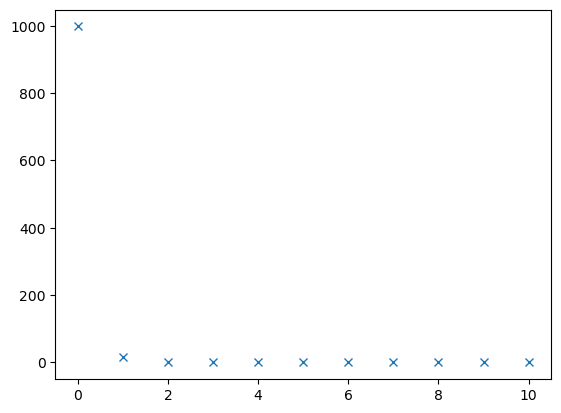

In [95]:
plt.plot(data_y[1],"x")

In [ ]:
# torch.save(data_x[1:],f"data_x_params_{num_param}_wzero_v8")
# torch.save(data_y[1:],f"data_y_mult_hist_{num_param}_wzeros_v8")


data_x_all = torch.cat((torch.load("sims/data_x_params_3_wzeros"),torch.load("sims/data_x_params_3_wzeros_v2"),torch.load("sims/data_x_params_3_wzeros_v3"),torch.load("sims/data_x_params_3_wzeros_v4"),torch.load("sims/data_x_params_2_wzero_v1"),torch.load("sims/data_x_params_2_wzero_v2"),torch.load("sims/data_x_params_2_wzero_v3"),torch.load("sims/data_x_params_2_wzero_v4"),torch.load("sims/data_x_params_2_wzero_v5"),torch.load("sims/data_x_params_2_wzero_v6"),torch.load("sims/data_x_params_2_wzero_v7"),torch.load("sims/data_x_params_2_wzero_v8"),torch.load("sims/data_x_params_2_wzeros_v9"),torch.load("sims/data_x_params_2_wzeros_v10"),torch.load("sims/data_x_params_2_wzeros_v11"),torch.load("sims/data_x_params_2_wzeros_v12"),torch.load("sims/data_x_params_2_wzeros_v13"),torch.load("sims/data_x_params_2_wzeros_v14")))
data_y_all = torch.cat((torch.load("sims/data_y_mult_hist_3_wzeros"),torch.load("sims/data_y_mult_hist_3_wzeros_v2"),torch.load("sims/data_y_mult_hist_3_wzeros_v3"),torch.load("sims/data_y_mult_hist_3_wzeros_v4"),torch.load("sims/data_y_mult_hist_2_wzeros_v1"),torch.load("sims/data_y_mult_hist_2_wzeros_v2"),torch.load("sims/data_y_mult_hist_2_wzeros_v3"),torch.load("sims/data_y_mult_hist_2_wzeros_v4"),torch.load("sims/data_y_mult_hist_2_wzeros_v5"),torch.load("sims/data_y_mult_hist_2_wzeros_v6"),torch.load("sims/data_y_mult_hist_2_wzeros_v7"),torch.load("sims/data_y_mult_hist_2_wzeros_v8"),torch.load("sims/data_y_mult_hist_2_wzeros_v9"),torch.load("sims/data_y_mult_hist_2_wzeros_v10"),torch.load("sims/data_y_mult_hist_2_wzeros_v11"),torch.load("sims/data_y_mult_hist_2_wzeros_v12"),torch.load("sims/data_y_mult_hist_2_wzeros_v13"),torch.load("sims/data_y_mult_hist_2_wzeros_v14")))

# # plt.hist(masked_cand["koi_model_snr"],[5,10,15,20,25,30,35,40,45,50,55,60,65,70],alpha=0.7,label="real")
# # plt.hist(snrs,[5,10,15,20,25,30,35,40,45,50,55,60,65,70],alpha=0.7,label="calculated")
# # plt.legend()
data_y_all.shape

torch.Size([3757, 11])

tensor([ 0.,  2.,  2.,  ..., 12., 12., 12.])


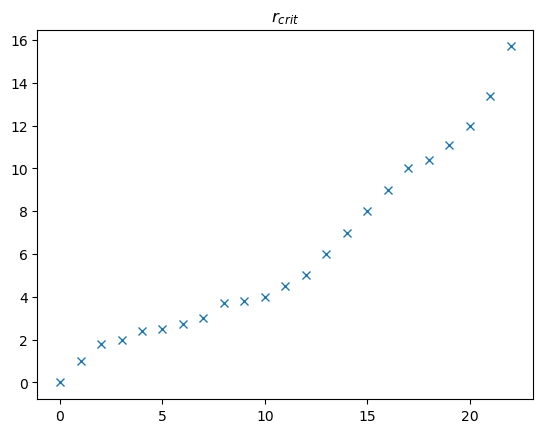

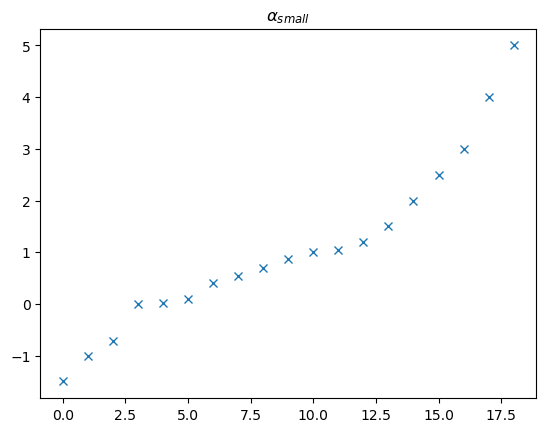

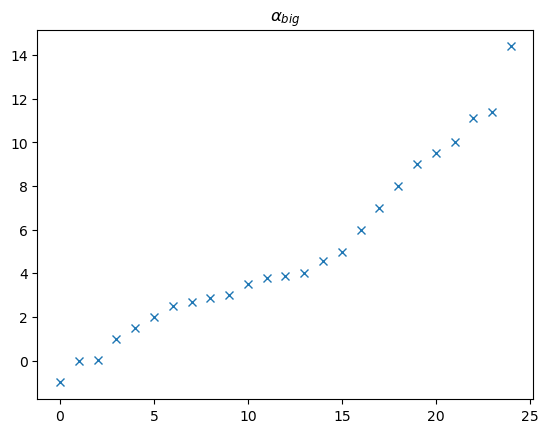

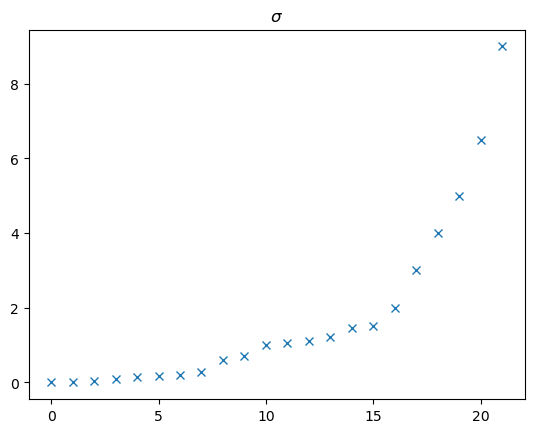

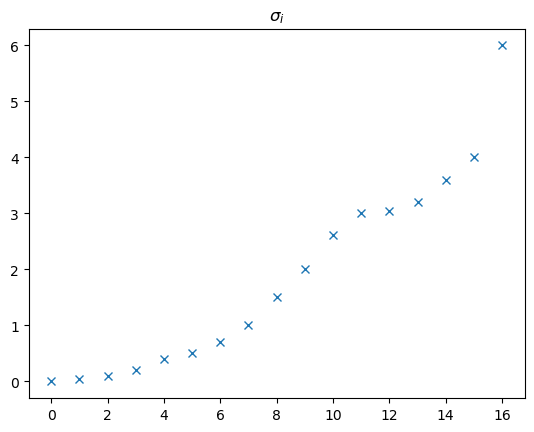

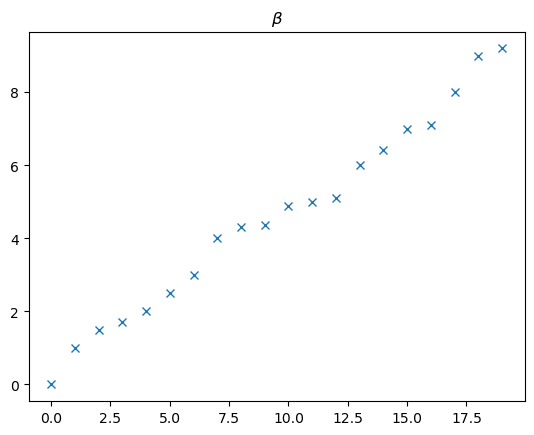

In [92]:
print(data_x_all[:,0])
labels = [r"$r_{crit}$", r"$\alpha_{small}$", r"$\alpha_{big}$", r"$\sigma$", r"$\sigma_i$", r"$\beta$"]
for i in range(6):
    plt.figure()
    plt.plot(torch.unique(data_x_all[:,i]), "x")
    plt.title(labels[i])

In [84]:
# Find unique rows and their counts
unique_rows, inverse_indices, counts = torch.unique(data_x_all, dim=0, return_inverse=True, return_counts=True)

# Create masks for unique rows and repeated rows
unique_mask = counts == 1
repeated_mask = counts > 1

# Extract indices for unique and repeated rows
unique_indices = torch.nonzero(unique_mask[inverse_indices], as_tuple=True)[0]
repeated_indices = torch.nonzero(repeated_mask[inverse_indices], as_tuple=True)[0]

# Create unique and repeated datasets using the indices
data_x_unique = data_x_all[unique_indices]
data_x_rep = data_x_all[repeated_indices]

data_y_unique = data_y_all[unique_indices]
data_y_rep = data_y_all[repeated_indices]

# Extract only the first instance of each repeated row
# Get unique rows in the repeated dataset
rep_unique_rows, rep_inverse_indices = torch.unique(data_x_rep, dim=0, return_inverse=True)

# Find the first occurrence index for each repeated row
first_instance_indices = []
for i in range(len(rep_unique_rows)):
    first_instance_index = torch.nonzero((data_x_rep == rep_unique_rows[i]).all(dim=1), as_tuple=True)[0][0]
    first_instance_indices.append(first_instance_index)

# Convert to tensor
first_instance_indices = torch.tensor(first_instance_indices)

# Create subsets with only the first instance of repeated rows
data_x_rep_first = data_x_rep[first_instance_indices]
data_y_rep_first = data_y_rep[first_instance_indices]


zeros_mask1 = torch.where(data_y_unique==0)
data_y_nozeros1 = data_y_unique
data_y_nozeros1[zeros_mask1] = 10**(-1/np.log(10)) 
data_y_norm1 = torch.log10(data_y_nozeros1)/10
data_x_norm1 = data_x_unique/10
idx1 = torch.randperm(data_x_norm1.shape[0])


zeros_mask2 = torch.where(data_y_rep_first==0)
data_y_nozeros2 = data_y_rep_first
data_y_nozeros2[zeros_mask2] = 10**(-1/np.log(10))
data_y_norm2 = torch.log10(data_y_nozeros2)/10
data_x_norm2 = data_x_rep_first/10
idx2 = torch.randperm(data_x_norm2.shape[0])

inputs = data_x_norm1[idx1]
targets = data_y_norm1[idx1]

inputs_val = data_x_norm2[idx2]  # 1000 samples, each with 5 features
targets_val = data_y_norm2[idx2]  # 1000 targets, each a 3x11 matrix

inputs = torch.concatenate((inputs,inputs_val[:200]))
targets = torch.concatenate((targets,targets_val[:200]))

inputs_val = inputs_val[200:]
targets_val = targets_val[200:]

print("val: ",targets_val.shape[0], "train: ", targets.shape[0])


val:  610 train:  1554


In [85]:
import torch
import torch.nn as nn
import torch.optim as optim

class ThreeLayerMLP_1(nn.Module):
    def __init__(self):
        super(ThreeLayerMLP_1, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(6, 64)     # First hidden layer (input: 5 units, output: 64 units)
        self.fc2 = nn.Linear(64, 128)   # Second hidden layer (input: 64 units, output: 128 units)
        self.fc3 = nn.Linear(128, 6)   # Output layer (input: 128 units, output: 33 units)
        
        # Activation function
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Pass through the layers with activation
        x = self.relu(self.fc1(x))      # Input to first layer and activation
        x = self.dropout(x)
        x = self.relu(self.fc2(x))      # Second layer and activation
        x = self.fc3(x)           # Output layer (no activation if regression task)
        
        # Reshape to (3, 11)
        
        #x = x.view(-1, 11, 3)
        
        return x



class ThreeLayerMLP_2(nn.Module):
    def __init__(self):
        super(ThreeLayerMLP_2, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(6, 64)     # First hidden layer (input: 5 units, output: 64 units)
        self.fc2 = nn.Linear(64, 128)   # Second hidden layer (input: 64 units, output: 128 units)
        self.fc3 = nn.Linear(128, 5)   # Output layer (input: 128 units, output: 33 units)
        
        # Activation function
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Pass through the layers with activation
        x = self.relu(self.fc1(x))      # Input to first layer and activation
        x = self.dropout(x)
        x = self.relu(self.fc2(x))      # Second layer and activation
        x = self.fc3(x)           # Output layer (no activation if regression task)
        
        # Reshape to (3, 11)
        
        #x = x.view(-1, 11, 3)
        
        return x

class ThreeLayerMLP_3(nn.Module):
    def __init__(self):
        super(ThreeLayerMLP_3, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(7, 64)     # First hidden layer (input: 5 units, output: 64 units)
        self.fc2 = nn.Linear(64, 128)   # Second hidden layer (input: 64 units, output: 128 units)
        self.fc3 = nn.Linear(128, 1)   # Output layer (input: 128 units, output: 33 units)
        
        # Activation function
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Pass through the layers with activation
        x = self.relu(self.fc1(x))      # Input to first layer and activation
        x = self.dropout(x)
        x = self.relu(self.fc2(x))      # Second layer and activation
        x = self.fc3(x)           # Output layer (no activation if regression task)
        
        # Reshape to (3, 11)
        
        #x = x.view(-1, 11, 3)
        
        return x

# Example usage
# Example model and hyperparameters
model1 = ThreeLayerMLP_1()
model2 = ThreeLayerMLP_2()
model3 = ThreeLayerMLP_3()

learning_rate_1 = 0.001
learning_rate_2 = 0.005
learning_rate_3 = 0.0005
num_epochs_1 = 200
num_epochs_2 = 200
num_epochs_3 = 200
batch_size = 256
train_size = int(len(data_x_all)*0.75)

# Loss and optimizer
criterion1 = nn.MSELoss()  # Change this if it's a classification problem
criterion2 = nn.MSELoss() 
criterion3 = nn.MSELoss() 
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate_1)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate_2)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate_3)

# # Dummy dataset (replace with your actual data)

# zeros_mask = torch.where(data_y_all==0)
# data_y_nozeros = data_y_all
# data_y_nozeros[zeros_mask] = 0.00001 

# data_y_norm = torch.log10(data_y_nozeros)/10

# #data_y_norm = torch.cat((torch.log10(data_y_nozeros)/10,data_y_nozeros[:,0].reshape(len(data_y_nozeros),1)/10000),axis=-1)

# data_x_norm = data_x_all/10
# #data_y_norm = data_y_all

# #data_y_norm = torch.cat((data_y_norm,data_y_norm[:,5:]),axis=1)

# idx = torch.randperm(data_x_norm.shape[0])

# inputs = data_x_norm[idx][:train_size,:]  # 1000 samples, each with 5 features
# targets = data_y_norm[idx][:train_size,:] # 1000 targets, each a 3x11 matrix


# Data loader (optional, for batching)
dataset = torch.utils.data.TensorDataset(inputs, targets)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# inputs_val = data_x_norm[train_size:,:]  # 1000 samples, each with 5 features
# targets_val = data_y_norm[train_size:,:]  # 1000 targets, each a 3x11 matrix

# Data loader (optional, for batching)
dataset_val = torch.utils.data.TensorDataset(inputs_val, targets_val)
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)


In [86]:
train_losses_1 = []
val_losses_1 = []
min_val_loss_1 = 10000

# Training loop
for epoch in range(num_epochs_1):
    running_loss_1 = 0.0
    model1.train()
    for batch_inputs, batch_targets in data_loader:
        # Forward pass
        outputs1 = model1(batch_inputs)
        loss1 = criterion1(outputs1, batch_targets[:,:6])

        # Backward pass and optimization
        optimizer1.zero_grad()  # Zero the gradients
        
        loss1.backward()        # Backpropagation
 
        optimizer1.step()       # Update weights
 
        running_loss_1 += loss1.item()

    running_loss_val_1 = 0.0

    with torch.no_grad():
        model1.eval()
        for batch_inputs, batch_targets in data_loader_val:
            
            outputs1 = model1(batch_inputs)
            loss1 = criterion1(outputs1, batch_targets[:,:6])
            running_loss_val_1 += loss1.item()


    train_losses_1.append(running_loss_1/ len(data_loader))
    val_losses_1.append(running_loss_val_1/ len(data_loader_val))

    if running_loss_val_1/ len(data_loader_val) < min_val_loss_1:
        min_val_loss_1 = running_loss_val_1/ len(data_loader_val)
        best_model_1 = model1
        torch.save(best_model_1.state_dict(), "best_model_0to5")
    # Print loss for each epoch
    
    avg_loss = running_loss_1 / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs_1}], Loss: {avg_loss:.4f}")


print("Training complete!")

Epoch [1/200], Loss: 0.0609
Epoch [2/200], Loss: 0.0166
Epoch [3/200], Loss: 0.0064
Epoch [4/200], Loss: 0.0067
Epoch [5/200], Loss: 0.0042
Epoch [6/200], Loss: 0.0032
Epoch [7/200], Loss: 0.0028
Epoch [8/200], Loss: 0.0022
Epoch [9/200], Loss: 0.0021
Epoch [10/200], Loss: 0.0019
Epoch [11/200], Loss: 0.0016
Epoch [12/200], Loss: 0.0015
Epoch [13/200], Loss: 0.0013
Epoch [14/200], Loss: 0.0012
Epoch [15/200], Loss: 0.0011
Epoch [16/200], Loss: 0.0011
Epoch [17/200], Loss: 0.0009
Epoch [18/200], Loss: 0.0009
Epoch [19/200], Loss: 0.0008
Epoch [20/200], Loss: 0.0008
Epoch [21/200], Loss: 0.0008
Epoch [22/200], Loss: 0.0007
Epoch [23/200], Loss: 0.0007
Epoch [24/200], Loss: 0.0007
Epoch [25/200], Loss: 0.0006
Epoch [26/200], Loss: 0.0006
Epoch [27/200], Loss: 0.0006
Epoch [28/200], Loss: 0.0006
Epoch [29/200], Loss: 0.0006
Epoch [30/200], Loss: 0.0006
Epoch [31/200], Loss: 0.0005
Epoch [32/200], Loss: 0.0005
Epoch [33/200], Loss: 0.0005
Epoch [34/200], Loss: 0.0006
Epoch [35/200], Loss: 0

In [87]:

train_losses_2 = []
val_losses_2 = []
min_val_loss_2 = 10000

for epoch in range(num_epochs_2):
    running_loss_2 = 0.0
    model2.train()
    for batch_inputs, batch_targets in data_loader:
        # Forward pass
        
        outputs2 = model2(batch_inputs)
        loss2 = criterion2(outputs2, batch_targets[:,6:])

        # Backward pass and optimization
        optimizer2.zero_grad()
        loss2.backward()        # Backpropagation

        optimizer2.step()       # Update weights
        
        running_loss_2 += loss2.item()
       
    running_loss_val_2 = 0.0

    with torch.no_grad():
        model2.eval()
        for batch_inputs, batch_targets in data_loader_val:

            outputs2 = model2(batch_inputs)
            loss2 = criterion2(outputs2, batch_targets[:,6:])
            running_loss_val_2 += loss2.item()
    
    train_losses_2.append(running_loss_2/ len(data_loader))
    val_losses_2.append(running_loss_val_2/ len(data_loader_val))
    
    if running_loss_val_2/ len(data_loader_val) < min_val_loss_2:
        min_val_loss_2 = running_loss_val_2/ len(data_loader_val)
        best_model_2 = model2
        torch.save(best_model_2.state_dict(), "best_model_6to10")
    # Print loss for each epoch
    
    avg_loss = running_loss_2 / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs_2}], Loss: {avg_loss:.4f}")

Epoch [1/200], Loss: 0.0052
Epoch [2/200], Loss: 0.0018
Epoch [3/200], Loss: 0.0012
Epoch [4/200], Loss: 0.0010
Epoch [5/200], Loss: 0.0008
Epoch [6/200], Loss: 0.0007
Epoch [7/200], Loss: 0.0007
Epoch [8/200], Loss: 0.0006
Epoch [9/200], Loss: 0.0006
Epoch [10/200], Loss: 0.0005
Epoch [11/200], Loss: 0.0005
Epoch [12/200], Loss: 0.0005
Epoch [13/200], Loss: 0.0005
Epoch [14/200], Loss: 0.0005
Epoch [15/200], Loss: 0.0005
Epoch [16/200], Loss: 0.0005
Epoch [17/200], Loss: 0.0005
Epoch [18/200], Loss: 0.0004
Epoch [19/200], Loss: 0.0004
Epoch [20/200], Loss: 0.0004
Epoch [21/200], Loss: 0.0004
Epoch [22/200], Loss: 0.0004
Epoch [23/200], Loss: 0.0004
Epoch [24/200], Loss: 0.0004
Epoch [25/200], Loss: 0.0004
Epoch [26/200], Loss: 0.0004
Epoch [27/200], Loss: 0.0004
Epoch [28/200], Loss: 0.0004
Epoch [29/200], Loss: 0.0004
Epoch [30/200], Loss: 0.0004
Epoch [31/200], Loss: 0.0004
Epoch [32/200], Loss: 0.0004
Epoch [33/200], Loss: 0.0004
Epoch [34/200], Loss: 0.0004
Epoch [35/200], Loss: 0

In [88]:
train_losses_3 = []
val_losses_3 = []
min_val_loss_3 = 10000

# # data_y_norm_3 = data_y_nozeros[:,0]/10000
# # data_x_norm_3 = data_x_all/10

# # idx = torch.randperm(data_x_norm_3.shape[0])

# inputs_3 = data_x_norm_3[idx][:train_size,:]  # 1000 samples, each with 5 features
# targets_3 = data_y_norm_3[idx][:train_size] # 1000 targets, each a 3x11 matrix

data_y_norm_3_1 = data_y_unique[:,0]/10000
data_x_norm_3_1 = data_x_unique/10

idx1 = torch.randperm(data_x_norm_3_1.shape[0])

inputs_3 = data_x_norm_3_1[idx1] # 1000 samples, each with 5 features
targets_3 = data_y_norm_3_1[idx1] # 1000 targets, each a 3x11 matrix

# Data loader (optional, for batching)
dataset_3 = torch.utils.data.TensorDataset(inputs_3, targets_3)
data_loader_3 = torch.utils.data.DataLoader(dataset_3, batch_size=batch_size, shuffle=True)

# inputs_val_3 = data_x_norm_3[train_size:,:]  # 1000 samples, each with 5 features
# targets_val_3 = data_y_norm_3[train_size:]  # 1000 targets, each a 3x11 matrix

data_y_norm_3_2 = data_y_rep_first[:,0]/10000
data_x_norm_3_2 = data_x_rep_first/10

idx2 = torch.randperm(data_x_norm_3_2.shape[0])

inputs_val_3 = data_x_norm_3_2[idx2] # 1000 samples, each with 5 features
targets_val_3 = data_y_norm_3_2[idx2] # 1000 targets, each a 3x11 matrix

# Data loader (optional, for batching)
dataset_val_3 = torch.utils.data.TensorDataset(inputs_val_3, targets_val_3)
data_loader_val_3 = torch.utils.data.DataLoader(dataset_val_3, batch_size=batch_size, shuffle=True)


# Training loop
for epoch in range(num_epochs_3):
    running_loss_3 = 0.0
    model3.train()
    for batch_inputs, batch_targets in data_loader_3:
        # Forward pass
        outputs3 = model3(torch.concatenate((batch_inputs,torch.reshape(best_model_1(batch_inputs)[:,0],(batch_inputs.shape[0],1))),axis=1))
        loss3 = criterion3(outputs3, torch.reshape(batch_targets,(batch_targets.shape[0],1)))

        # Backward pass and optimization
        optimizer3.zero_grad()  # Zero the gradients
        
        loss3.backward()        # Backpropagation
 
        optimizer3.step()       # Update weights
 
        running_loss_3 += loss3.item()

    running_loss_val_3 = 0.0

    with torch.no_grad():
        model3.eval()
        for batch_inputs, batch_targets in data_loader_val_3:
            
            outputs3 = model3(torch.concatenate((batch_inputs,torch.reshape(best_model_1(batch_inputs)[:,0],(batch_inputs.shape[0],1))),axis=1))
            loss3 = criterion3(outputs3, torch.reshape(batch_targets,(batch_targets.shape[0],1)))
            running_loss_val_3 += loss3.item()


    train_losses_3.append(running_loss_3/ len(data_loader_3))
    val_losses_3.append(running_loss_val_3/ len(data_loader_val_3))

    if running_loss_val_3/ len(data_loader_val_3) < min_val_loss_3:
        min_val_loss_3 = running_loss_val_3/ len(data_loader_val_3)
        best_model_3 = model3
        torch.save(best_model_3.state_dict(), "best_model_0")
    # Print loss for each epoch
    
    avg_loss = running_loss_3 / len(data_loader_3)
    print(f"Epoch [{epoch+1}/{num_epochs_3}], Loss: {avg_loss:.4f}")


print("Training complete!")

Epoch [1/200], Loss: 21.8126
Epoch [2/200], Loss: 20.8053
Epoch [3/200], Loss: 20.0882
Epoch [4/200], Loss: 18.7566
Epoch [5/200], Loss: 17.5804
Epoch [6/200], Loss: 15.8229
Epoch [7/200], Loss: 14.4864
Epoch [8/200], Loss: 12.8369
Epoch [9/200], Loss: 10.6283
Epoch [10/200], Loss: 8.6194
Epoch [11/200], Loss: 7.0187
Epoch [12/200], Loss: 5.5998
Epoch [13/200], Loss: 4.3931
Epoch [14/200], Loss: 3.9060
Epoch [15/200], Loss: 3.1894
Epoch [16/200], Loss: 3.1397
Epoch [17/200], Loss: 3.0096
Epoch [18/200], Loss: 2.9413
Epoch [19/200], Loss: 2.9503
Epoch [20/200], Loss: 2.7917
Epoch [21/200], Loss: 2.9494
Epoch [22/200], Loss: 2.7041
Epoch [23/200], Loss: 2.5698
Epoch [24/200], Loss: 2.7383
Epoch [25/200], Loss: 2.5194
Epoch [26/200], Loss: 2.4182
Epoch [27/200], Loss: 2.2185
Epoch [28/200], Loss: 2.1585
Epoch [29/200], Loss: 2.3093
Epoch [30/200], Loss: 2.1459
Epoch [31/200], Loss: 2.0614
Epoch [32/200], Loss: 2.0194
Epoch [33/200], Loss: 1.8154
Epoch [34/200], Loss: 1.8409
Epoch [35/200]

Text(0.5, 0, 'epoch')

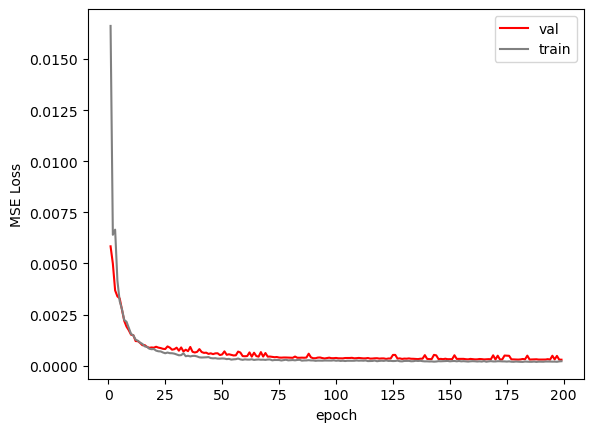

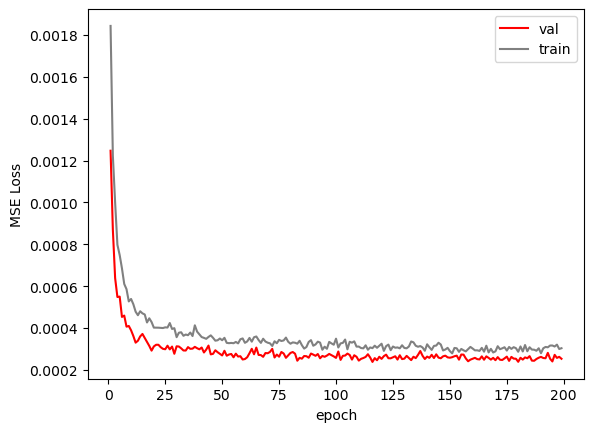

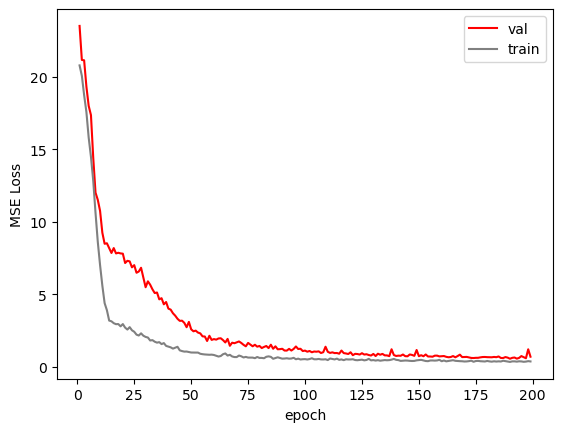

In [89]:
plt.figure()
plt.plot(range(1,num_epochs_1),val_losses_1[1:],color="red",label="val")
plt.plot(range(1,num_epochs_1),train_losses_1[1:],color="gray",label="train")
plt.legend()
plt.ylabel("MSE Loss")
plt.xlabel("epoch")

plt.figure()
plt.plot(range(1,num_epochs_2),val_losses_2[1:],color="red",label="val")
plt.plot(range(1,num_epochs_2),train_losses_2[1:],color="gray",label="train")
plt.legend()
plt.ylabel("MSE Loss")
plt.xlabel("epoch")

plt.figure()
plt.plot(range(1,num_epochs_3),val_losses_3[1:],color="red",label="val")
plt.plot(range(1,num_epochs_3),train_losses_3[1:],color="gray",label="train")
plt.legend()
plt.ylabel("MSE Loss")
plt.xlabel("epoch")


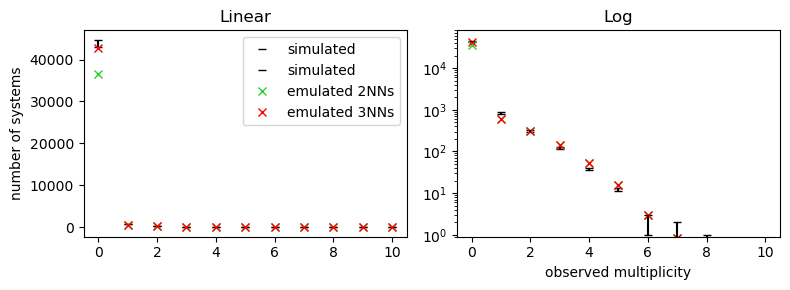

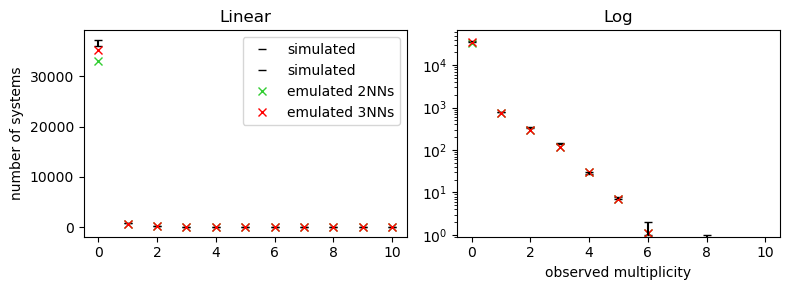

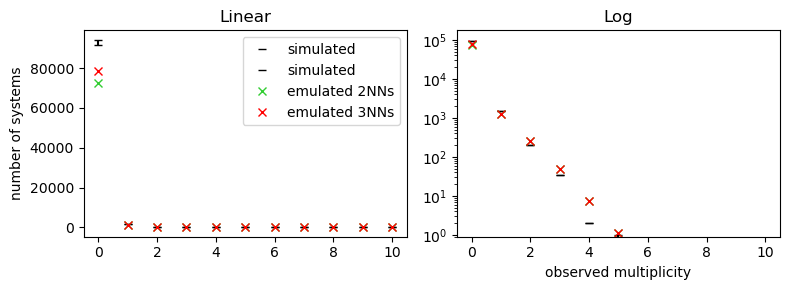

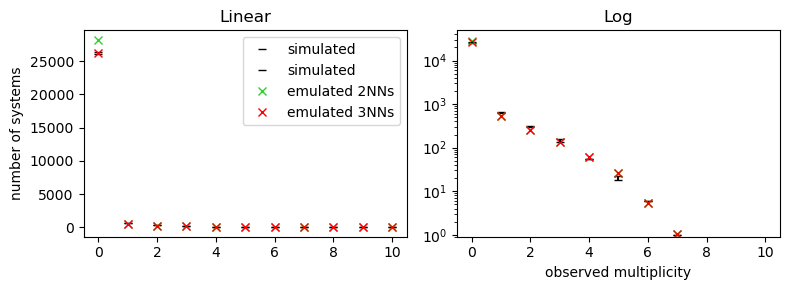

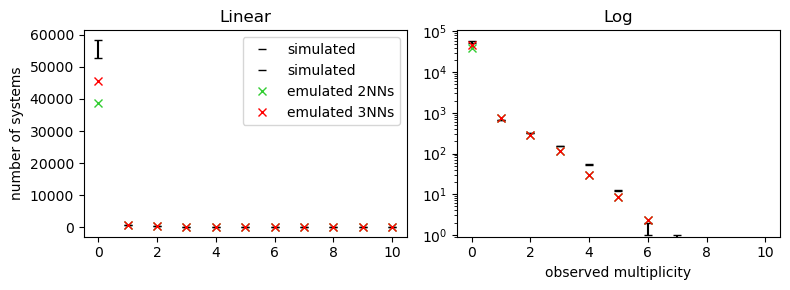

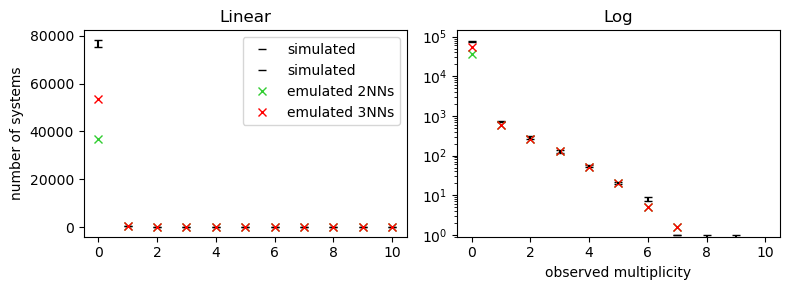

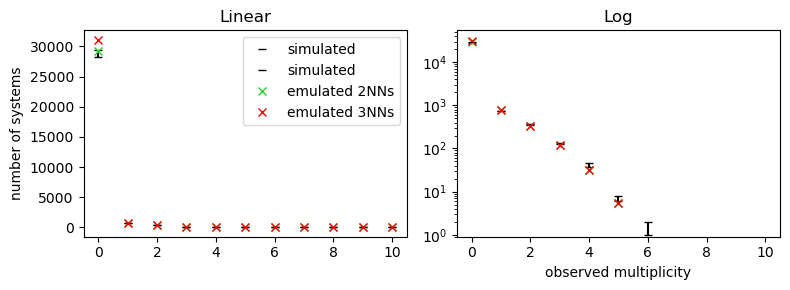

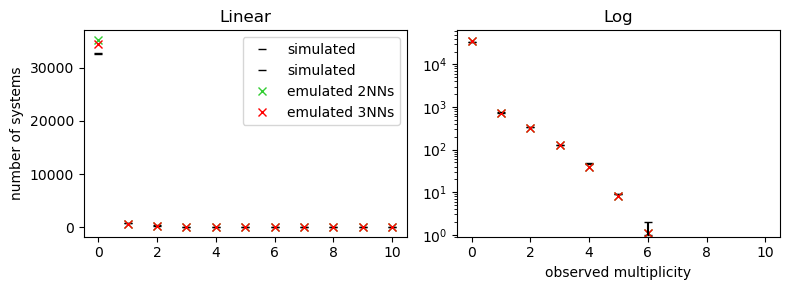

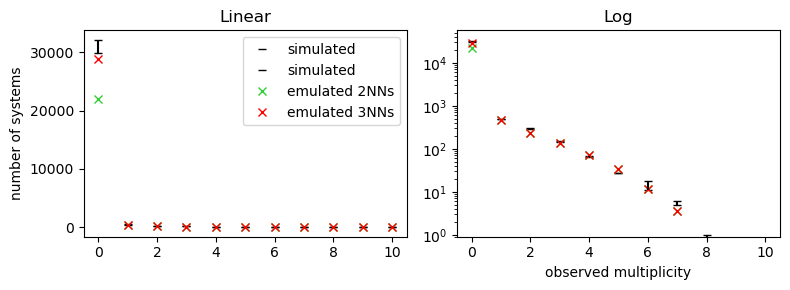

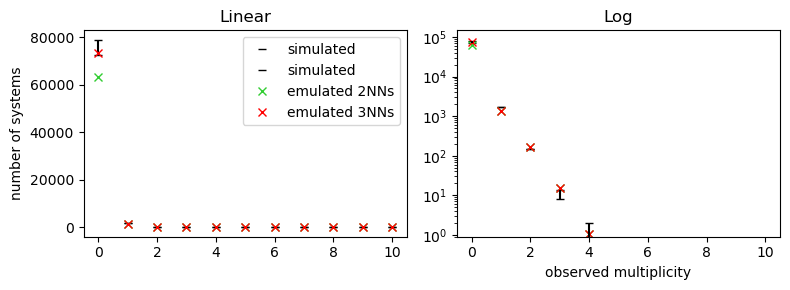

In [90]:
emulated_100 = []
emulated_nozeros = []
for i in range(10):
    model3_input = torch.concatenate((inputs_val,torch.reshape(best_model_1(inputs_val)[:,0],(inputs_val.shape[0],1))),axis=1)
    emulated_100.append(np.concatenate((10000*best_model_3(model3_input).detach().numpy(),10**(10*best_model_1(inputs_val).detach().numpy()[:,1:]),10**(10*best_model_2(inputs_val).detach().numpy())),axis=1))
    emulated_nozeros.append(np.concatenate((10**(10*best_model_1(inputs_val).detach().numpy()),10**(10*best_model_2(inputs_val).detach().numpy())),axis=1))

emulated = np.mean(emulated_100,axis=0)
emulated[np.where(emulated == 1)] = 0


emulated_nozeros = np.mean(emulated_nozeros,axis=0)
emulated_nozeros[np.where(emulated_nozeros == 1)] = 0

# simulated = 10**(10*targets_val)
# simulated[torch.where(simulated==0.00001)] = 0

all_hists_for_reps = []

for i in inputs_val[:10]:
    matches = torch.isclose(data_x_rep, i*10, atol=1e-2).all(dim=1)
    matching_indices = torch.nonzero(matches, as_tuple=True)[0]
    all_hists_for_reps.append(data_y_rep[matching_indices])


simulated = all_hists_for_reps

for i in range(10):

    fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8,3))

    # Plot the first subplot (linear plot)
    axs[0].plot(range(0,11),simulated[i][0],"_",color="black",label="simulated")
    axs[0].plot(range(0,11),simulated[i][1],"_",color="black",label="simulated")
    axs[0].vlines(range(0,11), simulated[i][0], simulated[i][1],color="black")
    axs[0].plot(range(0,11),emulated_nozeros[i],"x",color="limegreen",label="emulated 2NNs")
    axs[0].plot(range(0,11),emulated[i],"x",color="red",label="emulated 3NNs")
    
    
    axs[0].set_ylabel('number of systems')
    axs[0].set_title("Linear")
    axs[0].legend()

    # Plot the second subplot (semilogy)
    axs[1].semilogy(range(0,11),simulated[i][0],"_",color="black",label="simulated")
    axs[1].semilogy(range(0,11),simulated[i][1],"_",color="black",label="simulated")
    axs[1].semilogy(range(0,11),emulated_nozeros[i],"x",color="limegreen",label="emulated 2NNs")
    axs[1].semilogy(range(0,11),emulated[i],"x",color="red",label="emulated 3NNs")
    axs[1].vlines(range(0,11), simulated[i][0], simulated[i][1],color="black")
    
    axs[1].set_ylim(bottom=0.9)    
    axs[1].set_xlabel('observed multiplicity')
    axs[1].set_title("Log")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    #plt.savefig(f"2v3nns{i}.png")


tensor([3.1569e+04, 1.1270e+03, 3.3400e+02, 7.3000e+01, 1.1000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])


In [458]:
observation, _ = np.histogram(all_stars_in_selected_stars["nconfp"],bins = range(0,12))


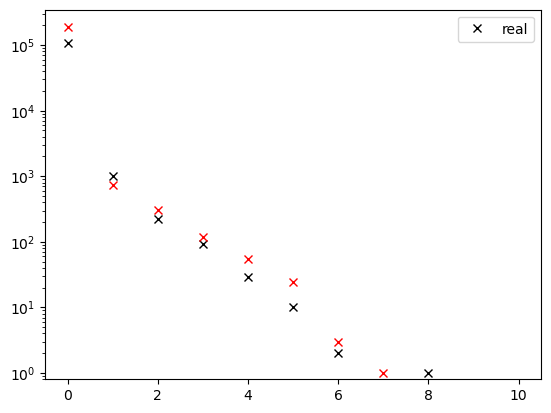

In [308]:
plt.figure()
plt.semilogy(range(0,11),observation,'x',color = "black",label="real")
plt.semilogy(range(0,11),data_y,'x',color="red")
plt.ylim(bottom=0.8)
plt.legend()
#plt.xlim(right=5,left=1)
